In [1]:
import re

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import BRICS
import torch
import torch.nn.functional as F
from torch_geometric.nn import MLP
from torch_geometric.loader import DataLoader

import XAIChem

In [2]:
model = XAIChem.RGCN(
    num_node_features=XAIChem.getNumAtomFeatures(),
    num_rgcn_layers=3,
    num_mlp_hidden_units=128,
    rgcn_dropout_rate=0.4,
    mlp_dropout_rate=0.0,
    use_fastrgcn=True,
    bclassification=True
).to('cpu')

paths = [
    f"../../data/trained_models/Mutagenicity/Mutagenicity_rgcn_model_{model_id}_early_stop.pt"
    for model_id in range(10)
]

models = XAIChem.loadModels(model, paths)

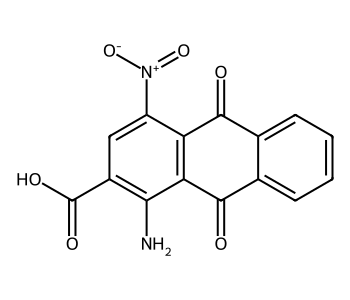

In [3]:
compound3_smiles = "Nc1c(C(=O)O)cc([N+](=O)[O-])c2c1C(=O)c1ccccc1C2=O"
compound3_mol = Chem.MolFromSmiles(compound3_smiles)
XAIChem.showMolecule(compound3_mol)

## Functional group attributions

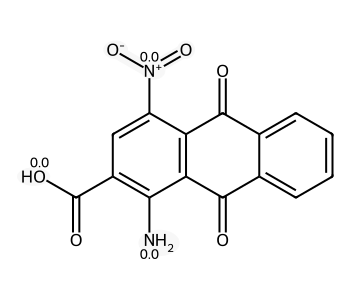

In [4]:
attributions_mask = XAIChem.functionalGroupAttributionScores(compound3_smiles, models, method="mask")
XAIChem.showMolecule(
    compound3_mol,
    attributions_mask.set_index("substructure").attribution.to_dict()
)

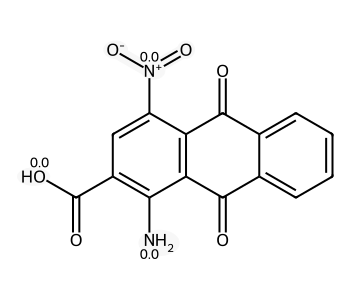

In [5]:
attributions_structure = XAIChem.functionalGroupAttributionScores(compound3_smiles, models, method="structure")
XAIChem.showMolecule(
    compound3_mol,
    attributions_structure.set_index("substructure").attribution.round(3).to_dict()
)

## BRICKS substructure attributions

In [167]:
bricks_substructures = [
    substructure
    for bond in BRICS.FindBRICSBonds(compound3_mol)
    for substructure in XAIChem.breakBRICKSBond(compound3_mol, bond[0])
]

In [168]:
masks = torch.concat([
    XAIChem.createMask(compound3_mol, bricks_substructure)
    for bricks_substructure in bricks_substructures
], dim=1)

compound3_graph = XAIChem.createDataObjectFromRdMol(compound3_mol, -1)

In [172]:
data_batch = DataLoader([compound3_graph for _ in range(masks.shape[1])], batch_size=masks.shape[1])

pred = XAIChem.predict(compound3_graph, models).item()
for data in data_batch:
    pred_masked = XAIChem.predictBatch(data, models, masks.view(-1, 1))

pd.DataFrame.from_dict({
    "substructure": bricks_substructures,
    "attribution": pred - pred_masked,
    "predictions": pred,
    "prediction_masked": pred_masked,
})

,substructure,attribution,predictions,prediction_masked
0,"[3, 4, 5]",0.000000e+00,1.0,1.0
1,"[2, 1, 6, 0, 12, 7, 11, 13, 8, 21, 14, 15, 9, ...",3.576279e-07,1.0,1.0


In [98]:
# Create new molecules from bricks fragments
brick_substructures = [
    Chem.MolFromSmiles(re.sub("\[\d+\*\]", "", frag)) 
    for frag in BRICS.BRICSDecompose(compound3_mol)
]

In [145]:
# Predict the mutagenicity of the fragment molecule. The mask is created 
# by the atoms that are not part of this BRICS fragment.
masked_predictions = dict()
pred = XAIChem.predict(compound3_graph, models).item()

for mol in mols:
    graph = XAIChem.createDataObjectFromRdMol(mol, -1)
    pred_masked = np.round(XAIChem.predict(graph, models).item(), 3)
    
    substructure_atom_ids = compound3_mol.GetSubstructMatch(mol)
    mask_atom_ids = tuple(
        atom.GetIdx() for atom in compound3_mol.GetAtoms() 
        if atom.GetIdx() not in substructure_atom_ids
    )
    
    masked_predictions[mask_atom_ids] = pred - pred_masked

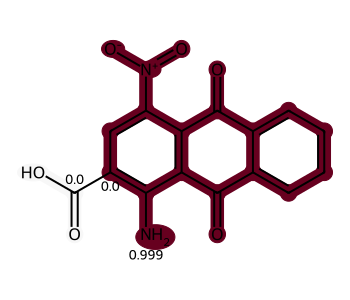

In [154]:
XAIChem.showMolecule(compound3_mol, masked_predictions, colorscale="RdBu_r")